# 275 Bird Species also see 73 Sports Dataset

今までのPyTorchの学習を活かして、実際にデータを分類してみる。

今回用いるデータは、Kaggleに上がっていた、２７５種類の鳥の分類問題である。

詳細は、https://www.kaggle.com/gpiosenka/100-bird-species

## ライブラリのインポート

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

## デバイスの確認

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

## データの前処理

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [4]:
train_dataset = datasets.ImageFolder('./archive/train', transform=transform)
validation_dataset = datasets.ImageFolder('./archive/test', transform=transform)

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

In [6]:
data_iter = iter(train_dataloader)
imgs, labels = data_iter.next()
labels

tensor([ 12, 164, 269, 225,  83,   0, 173, 215,  61,  31,  53, 177, 250, 229,
         66, 242])

In [7]:
imgs.size()

torch.Size([16, 3, 224, 224])

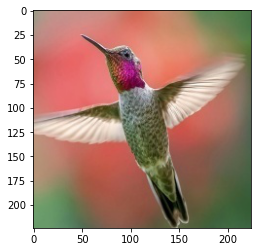

In [8]:
img = imgs[0]
img_permute = img.permute(1, 2, 0)
img_permute = 0.5 * img_permute + 0.5
img_permute = np.clip(img_permute, 0, 1)
plt.imshow(img_permute)

## モデルの構築

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=28 * 28 * 128, out_features=num_classes)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [10]:
cnn = CNN(275)
cnn.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=100352, out_features=275, bias=True)
)

## 学習・検証

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [12]:
num_epochs = 10
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = cnn(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = cnn(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc +=torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print('epoch: {}, loss: {}, acc: {},\t val_loss: {}, val_acc: {}'.format(
        epoch, running_loss, running_acc, val_running_loss, val_running_acc))

C:\Users\lear0\anaconda3\envs\pytorch_env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0, loss: 5.270148431998063, acc: 0.043376676738262177,	 val_loss: 4.92230993647908, val_acc: 0.07776162773370743
epoch: 1, loss: 4.4387570462155175, acc: 0.13434579968452454,	 val_loss: 4.40183177382447, val_acc: 0.15780039131641388
epoch: 2, loss: 3.1626231812791388, acc: 0.3341883420944214,	 val_loss: 4.498251953790354, val_acc: 0.21303294599056244
epoch: 3, loss: 1.8025936135210094, acc: 0.5991467237472534,	 val_loss: 6.417468392571737, val_acc: 0.2159883826971054
epoch: 4, loss: 0.9443520940779695, acc: 0.7833197712898254,	 val_loss: 8.761309088662614, val_acc: 0.21816861629486084
epoch: 5, loss: 0.47091850764335347, acc: 0.8905170559883118,	 val_loss: 14.303115855815799, val_acc: 0.2072189897298813
epoch: 6, loss: 0.2302109731825115, acc: 0.9455506205558777,	 val_loss: 16.704646504202554, val_acc: 0.21167635917663574
epoch: 7, loss: 0.11575794698507313, acc: 0.9724451303482056,	 val_loss: 19.818622029104898, val_acc: 0.22102713584899902
epoch: 8, loss: 0.0653809740402362, a

AttributeError: module 'matplotlib.pyplot' has no attribute 'sytle'

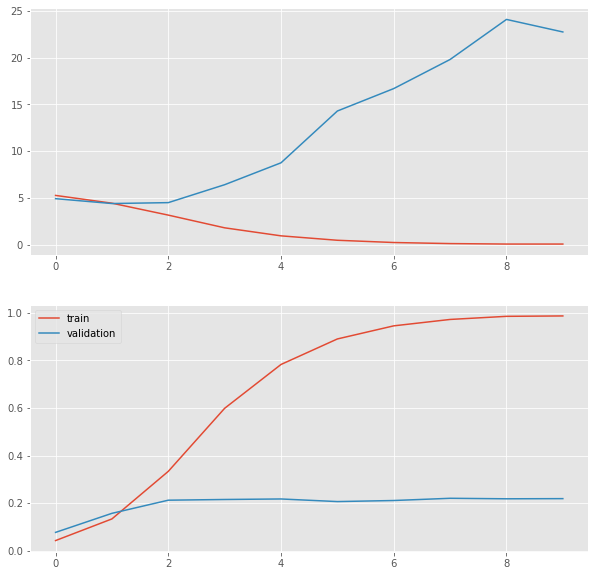

In [13]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(losses, label='train')
plt.plot(val_losses, label='validation')

plt.subplot(2, 1, 2)
plt.plot(accs, label='train')
plt.plot(val_accs, label='validation')

plt.legend()

## まとめ
結果については、過学習が起こっていることが確認できる。そのため、次回は

- データ拡張を行う。
- 正則化を行う。


また、今回遭遇したトラブルは、

- ミニバッチのサイズを大きくすると、GPUがメモリ不足を起こす。
- ミニバッチのサイズと学習率の両方の考慮が必要である。

これらに気を付けて、これからも学習を続ける。
